In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin
from kdelearn.metrics import pi_kf

from matplotlib import cm

In [3]:
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"  # computer modern (latex default style)
matplotlib.rcParams["font.family"] = "STIXGeneral"

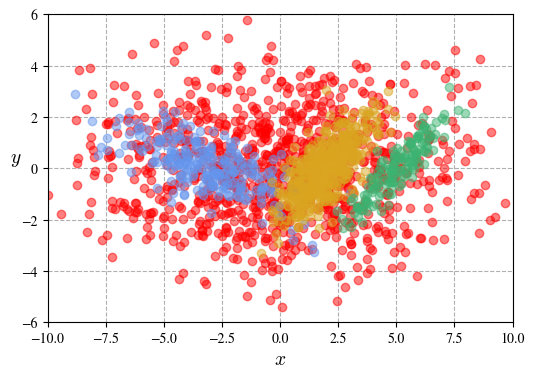

In [4]:
np.random.seed(1)

# Data
n_experiments = 1
m_train = 1000
n_x, n_y = 1, 1

# Class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
# Class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
# Class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
# Class 4
m_train4 = int(1.0 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]

m_train = m_train1 + m_train2 + m_train3 + m_train4

z_train = np.empty((n_experiments, m_train, n_x + n_y))
labels_train1 = np.full(m_train1, 1, dtype=np.int32)
labels_train2 = np.full(m_train2, 2, dtype=np.int32)
labels_train3 = np.full(m_train3, 3, dtype=np.int32)
labels_train4 = np.full(m_train4, 4, dtype=np.int32)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

for e in range(n_experiments):
    # Class 1
    z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
    # Class 2
    z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
    # Class 3
    z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
    # Class 4
    z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)

    z_train[e, :, :] = np.concatenate((z_train1, z_train2, z_train3, z_train4), axis=0)

x_train = z_train[:, :, [0]]
y_train = z_train[:, :, [1]]


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[0, -m_train4:], y_train[0, -m_train4:], c="red", zorder=2, alpha=0.5)
plt.scatter(x_train[0, :m_train1], y_train[0, :m_train1], c="cornflowerblue", zorder=2, alpha=0.5)
plt.scatter(x_train[0, m_train1:m_train1+m_train2], y_train[0, m_train1:m_train1+m_train2], c="goldenrod", zorder=2, alpha=0.5)
plt.scatter(x_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], y_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], c="mediumseagreen", zorder=2, alpha=0.5)

plt.xlim(-10, 10)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(linestyle="--")
# plt.savefig("synthetic_data.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [5]:
bandwidth_z = np.zeros((n_experiments, n_x + n_y))
for e in range(n_experiments):
    bandwidth_z[e] = direct_plugin(z_train[e])
bandwidth_x = bandwidth_z[:, :n_x]
bandwidth_y = bandwidth_z[:, n_x:]

x_grid = np.linspace(-10, 10, 1000)[:, None]

- $y^*=0$

- wskaźnik jak w bezwarunkowym - analiza w sąsiedztwie $y^*$

$$PI_{KF} = \frac{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{out} | y^*)}{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{in} | y^*)}$$

In [6]:
y_star = np.array([0.0] * n_y)

\newpage

# Analiza po r

In [7]:
r_grid = (0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.21)
print(f"Siatka dla r: {r_grid}")

Siatka dla r: (0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.21)


In [8]:
std = np.std(y_train[0, :, 0])
cond = (y_train[0, :, 0] > y_star[0]-std) & (y_train[0, :, 0] < y_star[0]+std)

x_train_tmp = x_train[0, cond]
y_train_tmp = y_train[0, cond]

x_train_tmp2 = x_train[0, ~cond]
y_train_tmp2 = y_train[0, ~cond]

Najlepsze r: 0.005
Przy wskaźniku jakości: 0.23218889445616184
Liczba elementów nietypowych: 10/1353 (0.739%)


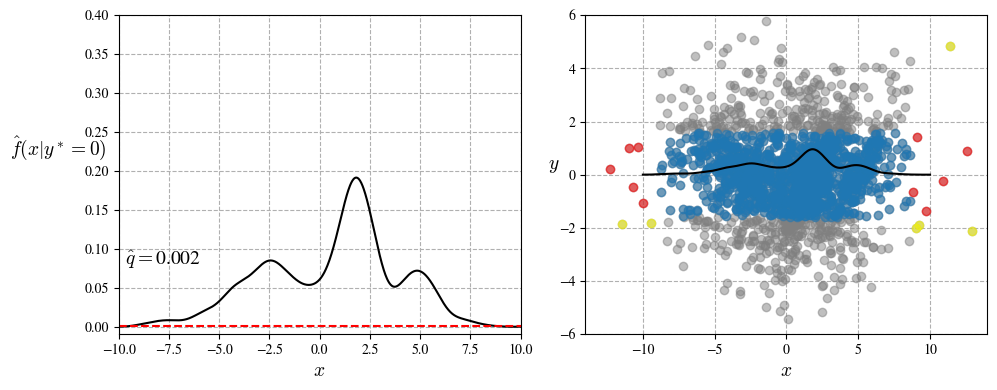

In [9]:
best_metric = np.inf
        
for r in r_grid:

    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                        bandwidth_x=bandwidth_x[0],
                                                        bandwidth_y=bandwidth_y[0],
                                                        r=r)
    labels_pred = ckde_outlier_detector.predict(x_train_tmp)

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()

    if n_outliers != 0:
        scores_train = ckde_outlier_detector.ckde.pdf(x_train_tmp)
        scores_out = scores_train[outliers]
        a = np.argsort(scores_train[inliers])
        scores_in = scores_train[inliers][a][:n_outliers]
        metric = np.sum(scores_out) / np.sum(scores_in)
    else:
        print(f"Brak nietypowych przy: {r}")
        continue

    if metric < best_metric:
        best_r = r
        best_metric = metric

print(f"Najlepsze r: {best_r:.3f}")
print(f"Przy wskaźniku jakości: {best_metric}")

##
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0],
                                                    bandwidth_y=bandwidth_y[0],
                                                    r=best_r)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train_tmp)
labels_pred2 = ckde_outlier_detector.predict(x_train_tmp2)
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()
print(f"Liczba elementów nietypowych: {n_outliers}/{x_train_tmp.shape[0]} ({100 * n_outliers/x_train_tmp.shape[0]:.3f}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0], y_train[0], zorder=2, alpha=0.5, c="gray")
axs[1].scatter(x_train_tmp2[labels_pred2==1], y_train_tmp2[labels_pred2==1], zorder=2, alpha=0.5, c="yellow")
axs[1].scatter(x_train_tmp[labels_pred==0], y_train_tmp[labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train_tmp[labels_pred==1], y_train_tmp[labels_pred==1], zorder=2, alpha=0.5, c="red")

axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-14, 14)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

\newpage

# Analiza po mnożniku h (odrębnie dla zmiennej $X$ i $Y$)

In [10]:
h_mul_grid = (1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 2.0, 0.4, 3.0, 0.3, 5.0, 0.2, 10.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 5.0, 10.0]


In [11]:
cond = (y_train[0, :, 0] > y_star[0]-std) & (y_train[0, :, 0] < y_star[0]+std)

x_train_tmp = x_train[0, cond]
y_train_tmp = y_train[0, cond]

x_train_tmp2 = x_train[0, ~cond]
y_train_tmp2 = y_train[0, ~cond]

Najlepszy mnożnik h_x: 0.40, h_y: 0.20
Przy wskaźniku jakości: 0.23736772045295768
Liczba elementów nietypowych: 205/1353 (15.152%)


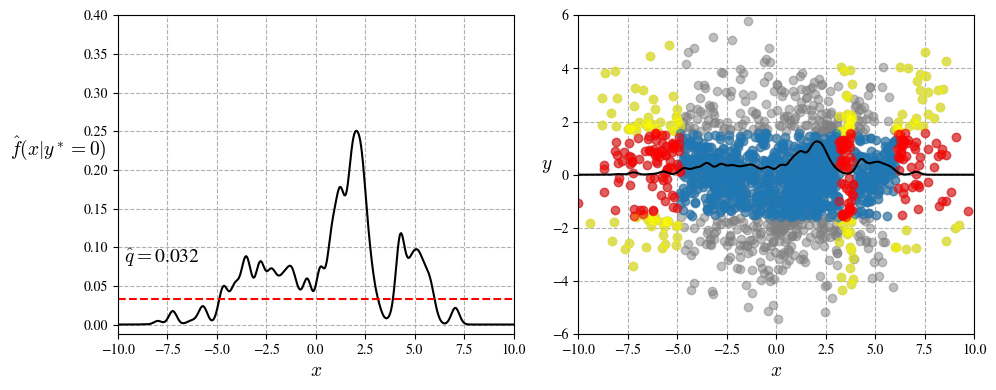

In [12]:
best_metric = np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        
        ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                            bandwidth_x=bandwidth_x[0] * h_mul_x,
                                                            bandwidth_y=bandwidth_y[0] * h_mul_y,
                                                            r=0.05)
        labels_pred = ckde_outlier_detector.predict(x_train_tmp)

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()

        if n_outliers != 0:
            scores_train = ckde_outlier_detector.ckde.pdf(x_train_tmp)
            scores_out = scores_train[outliers]
            a = np.argsort(scores_train[inliers])
            scores_in = scores_train[inliers][a][:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)
        else:
            print(f"Brak nietypowych przy h_mul_x: {h_mul_x}, h_mul_y: {h_mul_y}")

        if metric < best_metric:
            best_h_mul_x = h_mul_x
            best_h_mul_y = h_mul_y
            best_metric = metric

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Przy wskaźniku jakości: {best_metric}")

##
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0] * best_h_mul_x,
                                                    bandwidth_y=bandwidth_y[0] * best_h_mul_y,
                                                    r=0.05)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train_tmp)
labels_pred2 = ckde_outlier_detector.predict(x_train_tmp2)
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()
print(f"Liczba elementów nietypowych: {n_outliers}/{x_train_tmp.shape[0]} ({100 * n_outliers/x_train_tmp.shape[0]:.3f}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0], y_train[0], zorder=2, alpha=0.5, c="gray")
axs[1].scatter(x_train_tmp2[labels_pred2==1], y_train_tmp2[labels_pred2==1], zorder=2, alpha=0.5, c="yellow")
axs[1].scatter(x_train_tmp[labels_pred==0], y_train_tmp[labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train_tmp[labels_pred==1], y_train_tmp[labels_pred==1], zorder=2, alpha=0.5, c="red")

axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()

\newpage

# Analiza po a

In [13]:
a_grid = (0.04, 0.06, 0.08, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0)
print(f"Siatka dla a: {a_grid}")

Siatka dla a: (0.04, 0.06, 0.08, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0)


Najlepsze a: 2.0
Przy wskaźniku jakości: 0.27819595505779054
Liczba elementów nietypowych: 64/974 (6.571%)


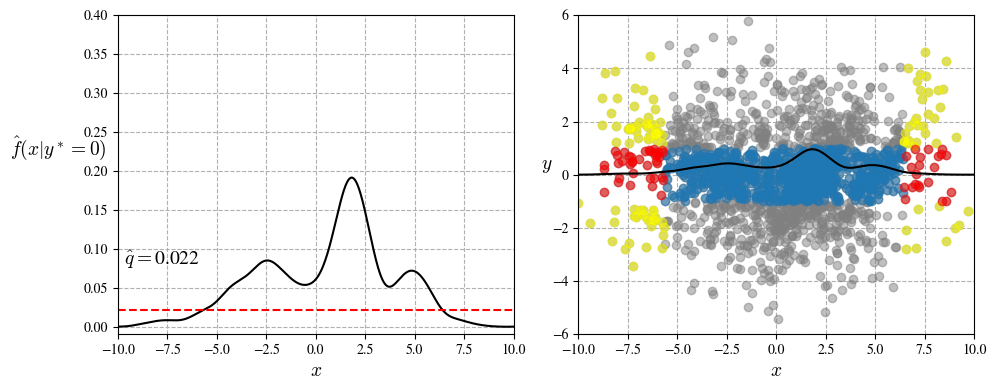

In [14]:
best_metric = np.inf
        
for a in a_grid:
    
    cond = (y_train[0, :, 0] > y_star[0]-a*std) & (y_train[0, :, 0] < y_star[0]+a*std)
    x_train_tmp = x_train[0, cond]
    y_train_tmp = y_train[0, cond]
    x_train_tmp2 = x_train[0, ~cond]
    y_train_tmp2 = y_train[0, ~cond]

    ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                        bandwidth_x=bandwidth_x[0],
                                                        bandwidth_y=bandwidth_y[0],
                                                        r=0.05)
    labels_pred = ckde_outlier_detector.predict(x_train_tmp)

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()

    if n_outliers != 0:
        scores_train = ckde_outlier_detector.ckde.pdf(x_train_tmp)
        scores_out = scores_train[outliers]
        tmp = np.argsort(scores_train[inliers])
        scores_in = scores_train[inliers][tmp][:n_outliers]
        metric = np.sum(scores_out) / np.sum(scores_in)
    else:
        print(f"Brak nietypowych przy a={a}")
        continue

    if metric < best_metric:
        best_a = a
        best_metric = metric

print(f"Najlepsze a: {best_a}")
print(f"Przy wskaźniku jakości: {best_metric}")

##
cond = (y_train[0, :, 0] > y_star[0]-best_a/2) & (y_train[0, :, 0] < y_star[0]+best_a/2)
x_train_tmp = x_train[0, cond]
y_train_tmp = y_train[0, cond]
x_train_tmp2 = x_train[0, ~cond]
y_train_tmp2 = y_train[0, ~cond]

ckde_outlier_detector = CKDEOutliersDetection().fit(x_train[0], y_train[0], y_star,
                                                    bandwidth_x=bandwidth_x[0],
                                                    bandwidth_y=bandwidth_y[0],
                                                    r=0.05)
scores = ckde_outlier_detector.ckde.pdf(x_grid)
labels_pred = ckde_outlier_detector.predict(x_train_tmp)
labels_pred2 = ckde_outlier_detector.predict(x_train_tmp2)
outliers = labels_pred == 1
n_outliers = (outliers == 1).sum()
print(f"Liczba elementów nietypowych: {n_outliers}/{x_train_tmp.shape[0]} ({100 * n_outliers/x_train_tmp.shape[0]:.3f}%)")


fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores, c="k")
axs[0].hlines(ckde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
axs[0].text(-9.7, 0.08, "$\hat{q} = $" + f"{ckde_outlier_detector.threshold:.3f}", fontsize=14)
axs[0].set_xlabel("$x$", fontsize=14)
axs[0].set_ylabel("$\hat{f}(x|y^*=" + f"{int(y_star[0])})$", rotation=0, fontsize=14, labelpad=16)
axs[0].yaxis.set_label_coords(-0.15, 0.54)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


axs[1].scatter(x_train[0], y_train[0], zorder=2, alpha=0.5, c="gray")
axs[1].scatter(x_train_tmp2[labels_pred2==1], y_train_tmp2[labels_pred2==1], zorder=2, alpha=0.5, c="yellow")
axs[1].scatter(x_train_tmp[labels_pred==0], y_train_tmp[labels_pred==0], zorder=2, alpha=0.5, c="#1f77b4")
axs[1].scatter(x_train_tmp[labels_pred==1], y_train_tmp[labels_pred==1], zorder=2, alpha=0.5, c="red")

axs[1].plot(x_grid, (5*scores+y_star[0]), c="k")
axs[1].set_xlabel("$x$", fontsize=14)
axs[1].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].grid(linestyle="--")

plt.tight_layout()
plt.show()